# **Face Mask Classification 😷**

**Key Specifications**
* Data import: `image_dataset_from_directory`
* Base-model: EfficientNetB3

**Additional Specifications**
* Image size: (256, 256, 3)
* Percentage for validation: 30%
* Batch size: 32
* Data augmentation: No
* Base-model non-trainable layers: 20 out of 384
* Post base-model layers:
    * Average 5x5
    * Dense with 512 neurons
    * Dropout with probability 50%

## **0.** Settings

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix
from IPython.display import Image, display
from tensorflow.keras import regularizers
from tensorflow import keras

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
import seaborn as sns
import numpy as np
import math
import cv2
import os

# Warnings off
import warnings
warnings.filterwarnings("ignore")

## **1.** Dataset

In [ ]:
!unzip '/content/drive/MyDrive/Face Mask/dataset.zip'

In [4]:
!ls /content

dataset  drive	sample_data


In [5]:
cwd = os.getcwd()
dataset_dir = os.path.join(cwd, 'dataset')

## **2.** Train and validation

In [6]:
img_h = 256
img_w = 256
batch_size = 32

train_dataset = image_dataset_from_directory(
    dataset_dir,
    shuffle          = True,
    batch_size       = batch_size,
    image_size       = (img_h, img_w),
    validation_split = 0.3,
    subset           = 'training',
    seed             = 420)

validation_dataset = image_dataset_from_directory(
    dataset_dir,
    shuffle          = True,
    batch_size       = batch_size,
    image_size       = (img_h, img_w),
    validation_split = 0.3,
    subset           = 'validation',
    seed             = 420)

classes = train_dataset.class_names
num_classes = len(classes)
print("There are ", num_classes, "classes: ", classes)

Found 5614 files belonging to 3 classes.
Using 3930 files for training.
Found 5614 files belonging to 3 classes.
Using 1684 files for validation.
There are  3 classes:  ['0', '1', '2']


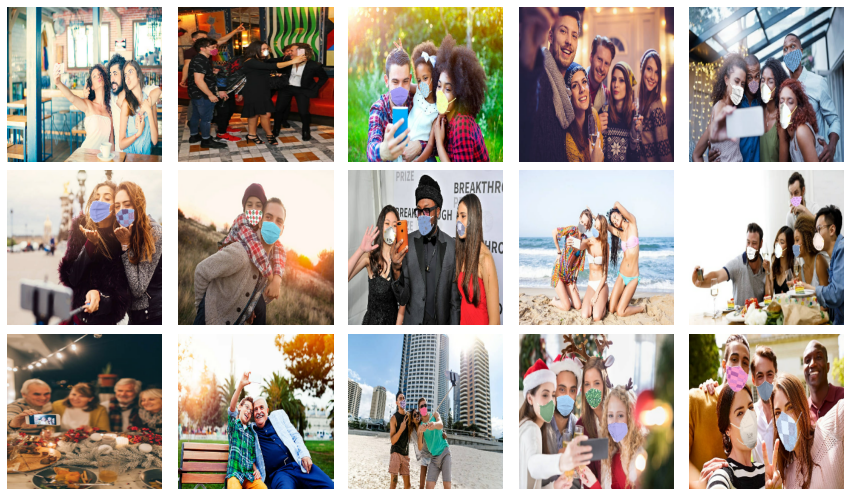

In [7]:
# Visualize some images 
plt.figure(figsize=(15, 9))
for images, labels in train_dataset.take(1):
  for i in range(15):
    plt.subplot(3, 5, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis('off')

plt.subplots_adjust(wspace=.1, hspace=.01)

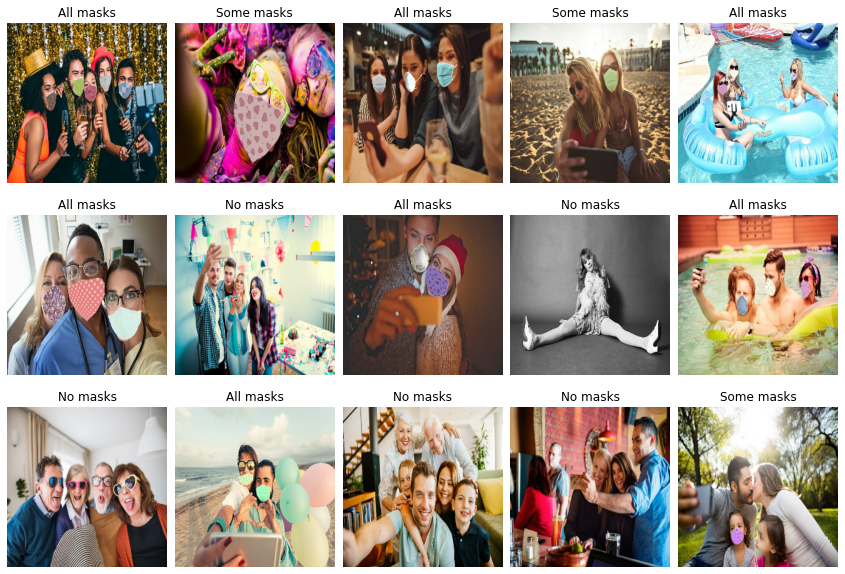

In [13]:
# Visualize some images with class
plt.figure(figsize=(15,10))
for images, labels in train_dataset.take(1):
  for i in range(15):
    plt.subplot(3, 5, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    if labels[i] == 0:
      plt.title('No masks');
    elif labels[i] == 1:
      plt.title('All masks');
    elif labels[i] == 2:
      plt.title('Some masks')
    plt.axis('off')

plt.subplots_adjust(wspace=.01, hspace=.2)

In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

Using `prefetch()` prevents a memory bottleneck that can occur when reading from disk. It sets aside some data and keeps it ready for when it's needed, by creating a source dataset from your input data, applying a transformation to preprocess it, then iterating over the dataset one element at a time. Because the iteration is streaming, the data doesn't need to fit into memory.

You can set the number of elements to prefetch manually, or you can use `tf.data.experimental.AUTOTUNE` to choose the parameters automatically. Autotune prompts `tf.data` to tune that value dynamically at runtime, by tracking the time spent in each operation and feeding those times into an optimization algorithm. The optimization algorithm tries to find the best allocation of its CPU budget across all tunable operations.

## **3.** Classes analysis

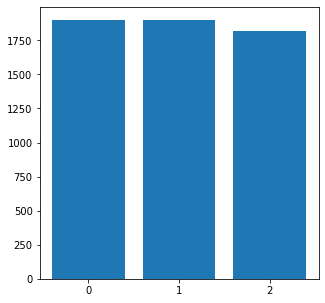

In [14]:
# Define a dictionary: {class: num_images}
class_dict = {}

# Count the number of images for each class
for label in classes:
  dir_path = dataset_dir + '/' + label
  count_elem = 0
  for path in os.listdir(dir_path):
    if os.path.isfile(os.path.join(dir_path, path)):
        count_elem += 1
  
  # Fill the dict
  class_dict[label] = count_elem

# Plot
fig, ax = plt.subplots(figsize=(5,5));
ax.bar(class_dict.keys(), class_dict.values());

## **4.** Define the model

In [22]:
# Base model
base_model = tf.keras.applications.EfficientNetB3(
    include_top = False,
    weights     = "imagenet",
    input_shape = (img_h, img_w, 3))

# Unfreeze all the layers
for layer in base_model.layers:
    layer.trainable = True

# Freeze the first 20 layers (out of 384)
for layer in base_model.layers[:20]:
    layer.trainable = False

# Build the model
x = tf.identity(base_model.output)
x = tf.keras.layers.AveragePooling2D(pool_size=(5,5))(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.models.Model(base_model.input, x)

In [ ]:
# Model visualization
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
# To get exact numbers
model.summary()

# Output:
# ==================================================================================================
# Total params: 11,572,018
# Trainable params: 11,480,993
# Non-trainable params: 91,025
# __________________________________________________________________________________________________

## **5.** Compile and train the model

In [23]:
# Maximum number of epochs
num_epochs = 500

# Optimizer
optimizer = tf.keras.optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=1e-08, decay=0.0)

# Loss function
loss_function = tf.keras.losses.SparseCategoricalCrossentropy()

# Metrics
metrics = ['accuracy']

# Compile
model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)

# To save the model
filepath = '/content/drive/MyDrive/Face Mask/' + 'model_03.hdf5'

# Callbacks
Early_Stopping = tf.keras.callbacks.EarlyStopping(
    monitor              = "val_loss", 
    restore_best_weights = False, 
    verbose              = 1, 
    patience             = 10)

Learning_Rate_Adapter = tf.keras.callbacks.ReduceLROnPlateau(
    monitor  = 'val_loss', 
    factor   = 0.2, 
    patience = 3, 
    verbose  = 1, 
    mode     = 'auto')

Best_model_save = tf.keras.callbacks.ModelCheckpoint(
    filepath       = filepath, 
    save_best_only = True, 
    monitor        = 'val_loss', 
    mode           = 'min', 
    verbose        = True)
 
callback = [Early_Stopping, Learning_Rate_Adapter, Best_model_save]

🟥 **Loss function `SparseCategoricalCrossentropy()`**<br>
Why in this case we use `SparseCategoricalCrossentropy()` and not `CategoricalCrossentropy()`?

If the labels are one-hot encoded (like in `flow_from_directory` case), we have to use `CategoricalCrossentropy()`.<br>
Examples (for a 3-class classification): `[1,0,0]` , `[0,1,0]`, `[0,0,1]`.

If, instead, the labels are integers (like in `image_dataset_from_directory`), we have to use `SparseCategoricalCrossentropy()`.<br>
Examples (for above 3-class classification problem): `[1]` , `[2]`, `[3]`.

In [24]:
history = model.fit(
    train_dataset, 
    epochs           = num_epochs,
    validation_data  = validation_dataset,
    callbacks        = callback)

Epoch 1/500
123/123 [==============================] - ETA: 0s - loss: 1.3784 - accuracy: 0.7000
Epoch 1: val_loss improved from inf to 1.43629, saving model to /content/drive/MyDrive/Face Mask/model_03.hdf5
123/123 [==============================] - 104s 709ms/step - loss: 1.3784 - accuracy: 0.7000 - val_loss: 1.4363 - val_accuracy: 0.7482 - lr: 1.0000
Epoch 2/500
123/123 [==============================] - ETA: 0s - loss: 0.9359 - accuracy: 0.8924
Epoch 2: val_loss improved from 1.43629 to 1.05559, saving model to /content/drive/MyDrive/Face Mask/model_03.hdf5
123/123 [==============================] - 85s 682ms/step - loss: 0.9359 - accuracy: 0.8924 - val_loss: 1.0556 - val_accuracy: 0.8557 - lr: 1.0000
Epoch 3/500
123/123 [==============================] - ETA: 0s - loss: 0.6952 - accuracy: 0.9634
Epoch 3: val_loss did not improve from 1.05559
123/123 [==============================] - 83s 673ms/step - loss: 0.6952 - accuracy: 0.9634 - val_loss: 1.1347 - val_accuracy: 0.8527 - lr: 1

## **6.** Model performance

### **6.1.** Trend of training loss and validation loss 

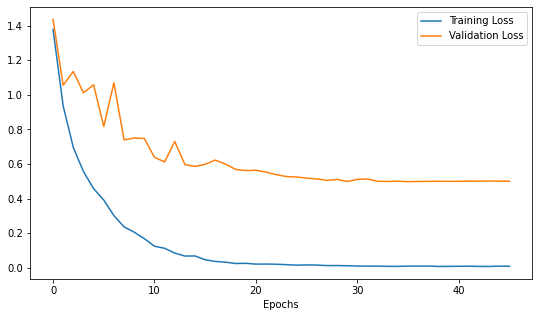

In [25]:
plt.figure(figsize=(9,5));
plt.plot(history.history['loss'], label='Training Loss');
plt.plot(history.history['val_loss'], label='Validation Loss');
plt.legend();
plt.xlabel('Epochs');

### **6.2.** Confusion matrix

In [10]:
# Load and evaluate the best model version
model = tf.keras.models.load_model(filepath)

In [11]:
val_labels = [] 
for img, label in validation_dataset.unbatch():
  val_labels.append(label.numpy())

train_labels = [] 
for img, label in train_dataset.unbatch():
  train_labels.append(label.numpy())

In [12]:
from collections import Counter

print('Training')
print('Labels: ', Counter(np.array(train_labels)).keys())
print('How many for each: ', Counter(np.array(train_labels)).values())

print('--')

print('Validation')
print('Labels: ', Counter(np.array(val_labels)).keys())
print('How many for each: ', Counter(np.array(val_labels)).values())

Training
Labels:  dict_keys([0, 2, 1])
How many for each:  dict_values([1326, 1273, 1331])
--
Validation
Labels:  dict_keys([1, 2, 0])
How many for each:  dict_values([566, 544, 574])


In [14]:
## We need to manually go and get the validation images (which are the last 30% of the dataset)

count = 0
y_true = []
y_pred = []

print('Label 0')
for i in os.listdir(dataset_dir + '/0'):
  count += 1

  if count > 1326 :  
    # One more label 0
    y_true.append(0)
    
    # Load image
    img = image.load_img(dataset_dir + '/0' + '/' + i, target_size=(img_h, img_w))

    # Define the label
    X = image.img_to_array(img)
    X = np.expand_dims(X, axis=0)
    images = np.vstack([X])
    y_pred.append(np.argmax(model.predict(images)))

print('Label 1')
count = 0
for i in os.listdir(dataset_dir + '/1'):
  count += 1

  if count > 1331 :  
    # One more label 1
    y_true.append(1)
    
    # Load image
    img = image.load_img(dataset_dir + '/1' + '/' + i, target_size=(img_h, img_w))

    # Define the label
    X = image.img_to_array(img)
    X = np.expand_dims(X, axis=0)
    images = np.vstack([X])
    y_pred.append(np.argmax(model.predict(images)))

print('Label 2')
count = 0
for i in os.listdir(dataset_dir + '/2'):
  count += 1

  if count > 1273 :  
    # One more label 1
    y_true.append(2)
    
    # Load image
    img = image.load_img(dataset_dir + '/2' + '/' + i, target_size=(img_h, img_w))

    # Define the label
    X = image.img_to_array(img)
    X = np.expand_dims(X, axis=0)
    images = np.vstack([X])
    y_pred.append(np.argmax(model.predict(images)))


Label 0
Label 1
Label 2


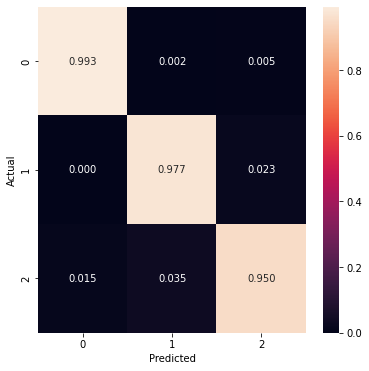

In [16]:
# Build the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Normalize the confusion matrix
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(cmn, annot=True, fmt='.3f', xticklabels=classes, yticklabels=classes);
plt.ylabel('Actual');
plt.xlabel('Predicted');

### **6.3** Other indeces

In [18]:
correct_labels = y_true
predicted_labels = y_pred

In [19]:
# Micro
# Calculate metrics globally by counting the total true positives, false negatives and false positives.
print('-----------------------------')
print('MICRO') 
print('-----------------------------')
print('Precision: %.5f' %precision_score(correct_labels, predicted_labels, pos_label='positive', average='micro'))
print('Recall: %.5f' % recall_score(correct_labels, predicted_labels, pos_label='positive', average='micro'))
print('Accuracy: %.5f' % accuracy_score(correct_labels, predicted_labels))
print('F1: %.5f' % f1_score(correct_labels, predicted_labels, pos_label='positive', average='micro'))

# Macro
# Calculate metrics for each label, and find their unweighted mean.
# This does not take label imbalance into account.
print('-----------------------------')
print('MACRO') 
print('-----------------------------')
print('Precision: %.5f' %precision_score(correct_labels, predicted_labels, pos_label='positive', average='macro'))
print('Recall: %.5f' % recall_score(correct_labels, predicted_labels, pos_label='positive', average='macro'))
print('Accuracy: %.5f' % accuracy_score(correct_labels, predicted_labels))
print('F1: %.5f' % f1_score(correct_labels, predicted_labels, pos_label='positive', average='macro'))

# Weighted
# Calculate metrics for each label, and find their average weighted by the number of true instances for each label.
# This alters ‘macro’ to account for label imbalance.
print('-----------------------------')
print('WEIGHTED')
print('-----------------------------')
print('Precision: %.5f' %precision_score(correct_labels, predicted_labels, pos_label='positive', average='weighted'))
print('Recall: %.5f' % recall_score(correct_labels, predicted_labels, pos_label='positive', average='weighted'))
print('Accuracy: %.5f' % accuracy_score(correct_labels, predicted_labels))
print('F1: %.5f' % f1_score(correct_labels, predicted_labels, pos_label='positive', average='weighted'))

-----------------------------
MICRO
-----------------------------
Precision: 0.97387
Recall: 0.97387
Accuracy: 0.97387
F1: 0.97387
-----------------------------
MACRO
-----------------------------
Precision: 0.97375
Recall: 0.97348
Accuracy: 0.97387
F1: 0.97356
-----------------------------
WEIGHTED
-----------------------------
Precision: 0.97385
Recall: 0.97387
Accuracy: 0.97387
F1: 0.97381


## **7.** Prediction

In [20]:
# Load and evaluate the best model version
model = tf.keras.models.load_model(filepath)

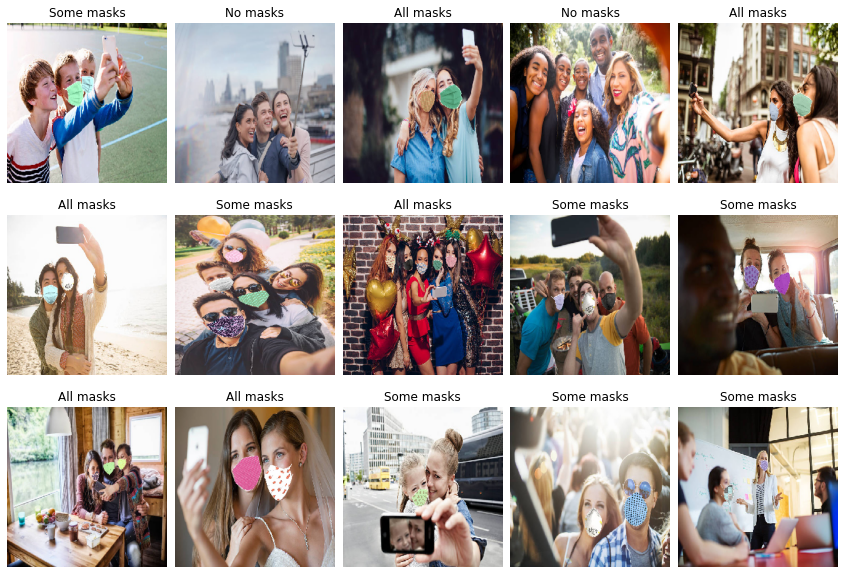

In [21]:
# Visualize the images with the predicted class
plt.figure(figsize=(15,10))

path_img_test = '/content/drive/MyDrive/Face Mask/test'

n = 0
for i in os.listdir(path_img_test):
  
  # Load image
  img = image.load_img(path_img_test + '/' + i, target_size=(img_h, img_w))
  
  # Define the plot
  plt.subplot(3, 5, n+1)
  plt.imshow(img)
  plt.axis("off")

  # Define the label
  X = image.img_to_array(img)
  X = np.expand_dims(X, axis=0)
  images = np.vstack([X])
  if np.argmax(model.predict(images))==0:
    plt.title('No masks')
  elif np.argmax(model.predict(images))==1:
    plt.title('All masks')
  else:
    plt.title('Some masks')

  # Iter
  n = n+1

plt.subplots_adjust(wspace=.01, hspace=.2)

## **8.** GradCAM

In [22]:
from tensorflow.keras.preprocessing import image
import matplotlib.cm as cm

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    #display(Image(cam_path))

    return cam_path

The heatmap: 


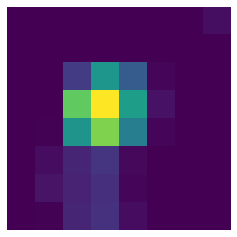


The image with the heatmap: 


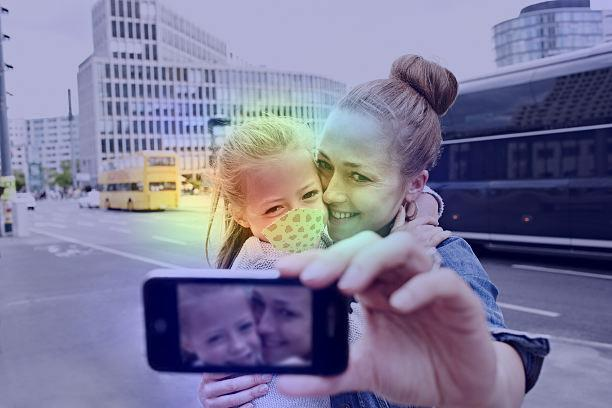

In [35]:
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = 'tf.identity_1'

# The local path to our target image
img_path  = '/content/drive/MyDrive/Face Mask/test/10040.jpg'
img_array = get_img_array(img_path, size=(img_h, img_w))

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
print("The heatmap: ")
plt.matshow(heatmap)
plt.axis('off')
plt.show()

# Display the image
print("\nThe image with the heatmap: ")
image = Image(save_and_display_gradcam(img_path, heatmap), width = 500, height = 350)
display(image)

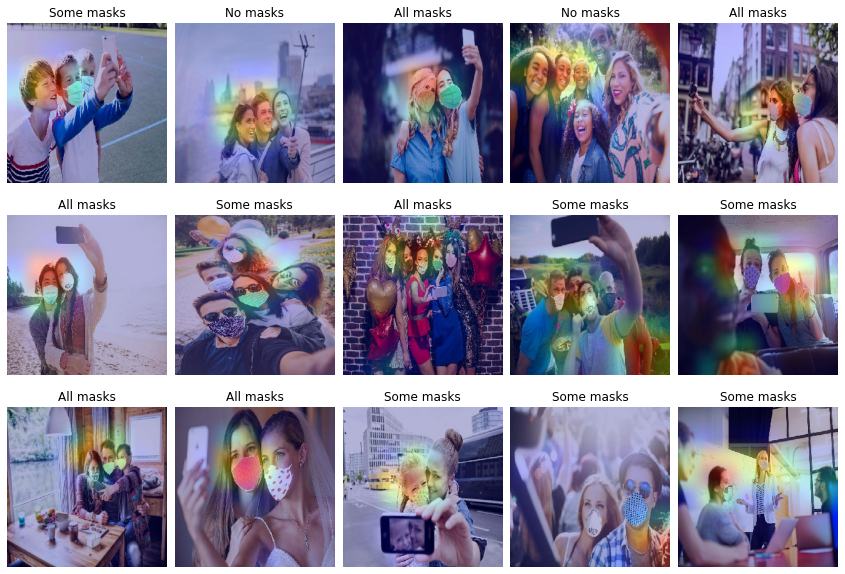

In [36]:
from keras.preprocessing import image

# Visualize the images with the predicted class
plt.figure(figsize=(15,10))

# For the GradCam (remove the last layer - softmax)
model.layers[-1].activation = None

n = 0
for i in os.listdir(path_img_test):
  
  # Load image
  img = image.load_img(path_img_test + '/' + i, target_size=(img_h, img_w))
  
  # GradCam
  img_path = path_img_test + '/' + i
  img_array = get_img_array(img_path, size=(img_h, img_w))
  heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
  img_2 = save_and_display_gradcam(img_path, heatmap)
  img_2 = image.load_img(img_2, target_size = (img_h, img_w))

  # Define the plot
  plt.subplot(3, 5, n+1)
  plt.imshow(img_2)
  plt.axis("off")

  # Define the label
  X = image.img_to_array(img)
  X = np.expand_dims(X, axis=0)
  images = np.vstack([X])
  if np.argmax(model.predict(images))==0:
    plt.title('No masks')
  elif np.argmax(model.predict(images))==1:
    plt.title('All masks')
  else:
    plt.title('Some masks')

  # Iter
  n = n+1

plt.subplots_adjust(wspace=.01, hspace=.2)